In [ ]:
#!pip3 install -U -r requirements.txt

In [ ]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=e9614a65189e79e72bad5148d23e0d16889b7cbe1495ebb18644825e463f6f98
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [ ]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

100%|██████████| 170M/170M [00:02<00:00, 71.9MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
data_variance = np.var(training_data.data / 255.0)

In [ ]:
# class VectorQuantizer(nn.Module):
#     def __init__(self, num_embeddings, embedding_dim, commitment_cost):
#         super(VectorQuantizer, self).__init__()

#         self._embedding_dim = embedding_dim
#         self._num_embeddings = num_embeddings

#         self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
#         self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
#         self._commitment_cost = commitment_cost

#     def forward(self, inputs):
#         # convert inputs from BCHW -> BHWC
#         inputs = inputs.permute(0, 2, 3, 1).contiguous()
#         input_shape = inputs.shape

#         # Flatten input
#         flat_input = inputs.view(-1, self._embedding_dim)

#         # Calculate distances
#         distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
#                     + torch.sum(self._embedding.weight**2, dim=1)
#                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

#         # Encoding
#         encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
#         encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
#         encodings.scatter_(1, encoding_indices, 1)

#         # Quantize and unflatten
#         quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

#         # Loss
#         e_latent_loss = F.mse_loss(quantized.detach(), inputs)
#         q_latent_loss = F.mse_loss(quantized, inputs.detach())
#         loss = q_latent_loss + self._commitment_cost * e_latent_loss

#         quantized = inputs + (quantized - inputs).detach()
#         avg_probs = torch.mean(encodings, dim=0)
#         perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

#         # convert quantized from BHWC -> BCHW
#         return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [ ]:
import torch
import torch.nn as nn

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, dropout_prob=0.2):
        """
        Vector Quantizer with Dropout applied to embeddings before distance calculation.

        Args:
            num_embeddings (int): Number of embedding vectors.
            embedding_dim (int): Dimensionality of each embedding vector.
            commitment_cost (float): Weight for the commitment loss.
            dropout_prob (float): Dropout probability (default: 0.2).
        """
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.dropout = nn.Dropout(p=dropout_prob)

        # Embedding initialization
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, inputs):
        """
        Forward pass with dropout on embeddings and vector quantization.
        Args:
            inputs (torch.Tensor): Input tensor of shape (batch_size, embedding_dim, height, width).
        Returns:
            tuple: (loss, quantized, perplexity, encodings)
        """
        # Flatten input to (batch_size * height * width, embedding_dim)
        inputs_flattened = inputs.view(-1, self.embedding_dim)

        # Apply dropout to embeddings
        embeddings_dropped = self.dropout(self.embedding.weight)

        # Compute distances between inputs and embeddings
        distances = (
            torch.sum(inputs_flattened**2, dim=1, keepdim=True)
            - 2 * torch.matmul(inputs_flattened, embeddings_dropped.T)
            + torch.sum(embeddings_dropped**2, dim=1)
        )

        # Find nearest embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Create one-hot encodings
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize the inputs
        quantized = torch.matmul(encodings, embeddings_dropped).view_as(inputs)

        # Commitment loss
        e_latent_loss = torch.mean((quantized.detach() - inputs) ** 2)
        q_latent_loss = torch.mean((quantized - inputs.detach()) ** 2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Add quantization noise to the gradients
        quantized = inputs + (quantized - inputs).detach()

        # Perplexity (for monitoring)
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized, perplexity, encodings


In [ ]:
# class VectorQuantizerEMA(nn.Module):
#     def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
#         super(VectorQuantizerEMA, self).__init__()

#         self._embedding_dim = embedding_dim
#         self._num_embeddings = num_embeddings

#         self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
#         self._embedding.weight.data.normal_()
#         self._commitment_cost = commitment_cost

#         self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
#         self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
#         self._ema_w.data.normal_()

#         self._decay = decay
#         self._epsilon = epsilon

#     def forward(self, inputs):
#         # convert inputs from BCHW -> BHWC
#         inputs = inputs.permute(0, 2, 3, 1).contiguous()
#         input_shape = inputs.shape

#         # Flatten input
#         flat_input = inputs.view(-1, self._embedding_dim)

#         # Calculate distances
#         distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
#                     + torch.sum(self._embedding.weight**2, dim=1)
#                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

#         # Encoding
#         encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
#         encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
#         encodings.scatter_(1, encoding_indices, 1)

#         # Quantize and unflatten
#         quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

#         # Use EMA to update the embedding vectors
#         if self.training:
#             self._ema_cluster_size = self._ema_cluster_size * self._decay + \
#                                      (1 - self._decay) * torch.sum(encodings, 0)

#             # Laplace smoothing of the cluster size
#             n = torch.sum(self._ema_cluster_size.data)
#             self._ema_cluster_size = (
#                 (self._ema_cluster_size + self._epsilon)
#                 / (n + self._num_embeddings * self._epsilon) * n)

#             dw = torch.matmul(encodings.t(), flat_input)
#             self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

#             self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

#         # Loss
#         e_latent_loss = F.mse_loss(quantized.detach(), inputs)
#         loss = self._commitment_cost * e_latent_loss

#         # Straight Through Estimator
#         quantized = inputs + (quantized - inputs).detach()
#         avg_probs = torch.mean(encodings, dim=0)
#         perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

#         # convert quantized from BHWC -> BCHW
#         return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, dropout_prob=0.2, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost
        self._decay = decay
        self._epsilon = epsilon

        # Embedding initialization
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()

        # EMA initialization
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Apply dropout to embeddings
        embeddings_dropped = self.dropout(self._embedding.weight)

        # Calculate distances
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(embeddings_dropped**2, dim=1)
            - 2 * torch.matmul(flat_input, embeddings_dropped.t())
        )

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, embeddings_dropped).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n
            )

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings


In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

## Train

In [ ]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [ ]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

In [ ]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [ ]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 1.011
perplexity: 1.000

200 iterations
recon_error: 0.983
perplexity: 1.000

300 iterations
recon_error: 0.983
perplexity: 1.000

400 iterations
recon_error: 0.981
perplexity: 1.000

500 iterations
recon_error: 0.977
perplexity: 1.000

600 iterations
recon_error: 0.896
perplexity: 1.395

700 iterations
recon_error: 0.683
perplexity: 1.847

800 iterations
recon_error: 0.383
perplexity: 3.651

900 iterations
recon_error: 0.265
perplexity: 9.063

1000 iterations
recon_error: 0.225
perplexity: 23.234

1100 iterations
recon_error: 0.186
perplexity: 39.603

1200 iterations
recon_error: 0.174
perplexity: 46.330

1300 iterations
recon_error: 0.166
perplexity: 48.670

1400 iterations
recon_error: 0.160
perplexity: 52.092

1500 iterations
recon_error: 0.156
perplexity: 54.747

1600 iterations
recon_error: 0.146
perplexity: 57.768

1700 iterations
recon_error: 0.139
perplexity: 59.876

1800 iterations
recon_error: 0.134
perplexity: 61.425

1900 iterations
recon_error:

KeyboardInterrupt: 

## Plot Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

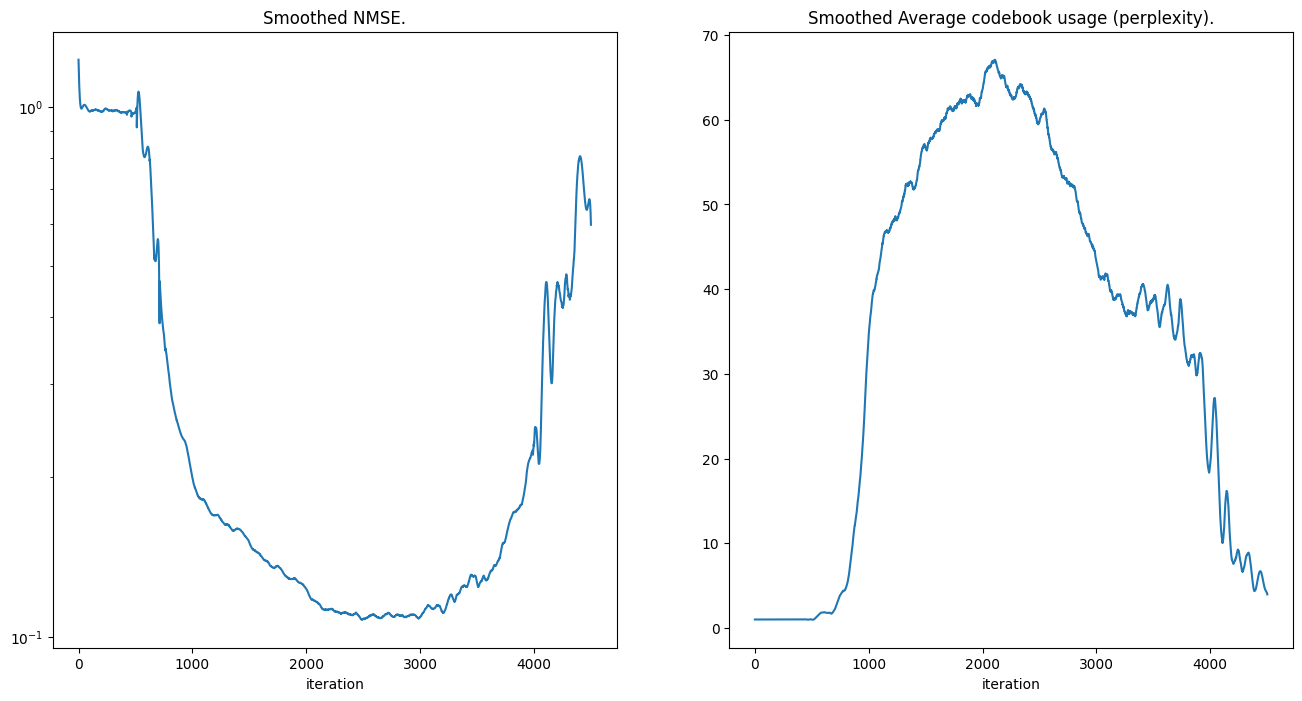

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [ ]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [ ]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

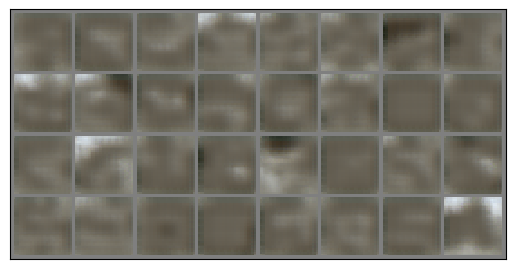

In [ ]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

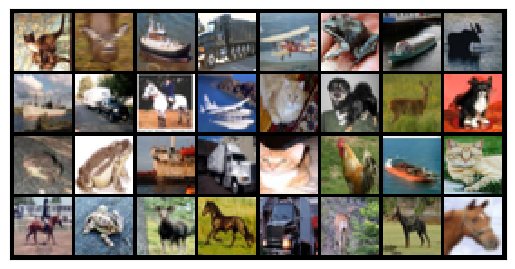

In [ ]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [ ]:
import umap  # 올바른 모듈 불러오기

proj = umap.UMAP(n_neighbors=3, min_dist=0.1, metric='cosine').fit_transform(
    model._vq_vae._embedding.weight.data.cpu()
)


AttributeError: module 'umap' has no attribute 'UMAP'

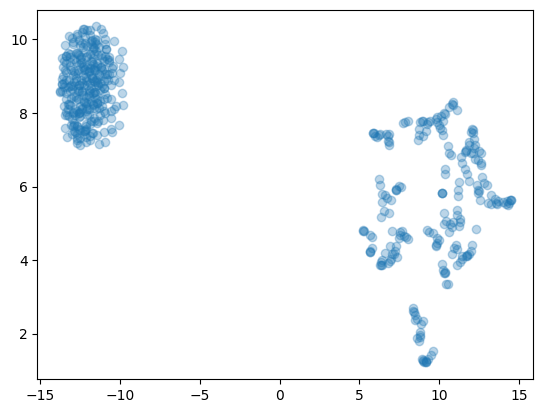

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)